In [28]:
# Configuration
IMAGE_PATH = "images/male.png"
MODEL_PATH = "models/pose_landmarker_heavy.task"

In [29]:
# Imports
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


In [30]:
# Load image
img = cv2.imread(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Image loaded: {img.shape}")


Image loaded: (1110, 740, 3)


In [31]:
# Initialize BlazePose detector
base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.PoseLandmarkerOptions(
    base_options=base_options, output_segmentation_masks=True
)
detector = vision.PoseLandmarker.create_from_options(options)

print("Pose detector initialized")


Pose detector initialized


I0000 00:00:1761620216.313498 1803645 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1761620216.408235 1848173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761620216.433695 1848174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [32]:
# Detect pose
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)
detection_result = detector.detect(image)

print(f"Detected {len(detection_result.pose_landmarks)} pose(s)")


Detected 1 pose(s)


In [33]:
# Draw landmarks on image
annotated_image = img_rgb.copy()

# Calculate scale factor based on image size
image_height, image_width = img_rgb.shape[:2]
scale_factor = min(image_width, image_height) / 720

# Drawing specifications
landmark_drawing_spec = solutions.drawing_utils.DrawingSpec(
    color=(255, 0, 0),  # Red landmarks
    thickness=max(1, int(2 * scale_factor)),
    circle_radius=max(1, int(4 * scale_factor)),
)
connection_drawing_spec = solutions.drawing_utils.DrawingSpec(
    color=(0, 255, 0),  # Green connections
    thickness=max(1, int(2 * scale_factor)),
)

# Draw each detected pose
for pose_landmarks in detection_result.pose_landmarks:
    # Convert to protobuf format
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend(
        [
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z)
            for landmark in pose_landmarks
        ]
    )

    # Draw landmarks and connections
    solutions.drawing_utils.draw_landmarks(
        annotated_image,
        pose_landmarks_proto,
        solutions.pose.POSE_CONNECTIONS,
        landmark_drawing_spec=landmark_drawing_spec,
        connection_drawing_spec=connection_drawing_spec,
    )

print("Landmarks drawn")


Landmarks drawn


In [34]:
"""
BlazePose outputs 33 body landmarks for each detected person.

TWO TYPES OF 3D COORDINATES:

1. NORMALIZED COORDINATES (pose_landmarks):
   - x, y: Range [0, 1], normalized to image dimensions
     * (0, 0) = top-left corner of image
     * (1, 1) = bottom-right corner of image
   - z: Depth relative to hip midpoint, roughly same scale as x
     * Smaller z = closer to camera
     * Larger z = farther from camera
   - USE CASE: When you need pixel positions on the image or screen-relative coords

2. WORLD COORDINATES (pose_world_landmarks):
   - x, y, z: ALL in METERS (real-world metric units)
   - Origin is at the hip center
   - Represents actual 3D spatial positions in the real world
   - USE CASE: When you need real distances (e.g., "elbow is 0.3m from shoulder")
     or to measure body proportions, track movement in 3D space, etc.

LANDMARK IDs (33 total):
0-nose, 1-left eye (inner), 2-left eye, 3-left eye (outer),
4-right eye (inner), 5-right eye, 6-right eye (outer),
7-left ear, 8-right ear, 9-mouth (left), 10-mouth (right),
11-left shoulder, 12-right shoulder, 13-left elbow, 14-right elbow,
15-left wrist, 16-right wrist, 17-left pinky, 18-right pinky,
19-left index, 20-right index, 21-left thumb, 22-right thumb,
23-left hip, 24-right hip, 25-left knee, 26-right knee,
27-left ankle, 28-right ankle, 29-left heel, 30-right heel,
31-left foot index, 32-right foot index
"""

# Extract 3D coordinates from first detected pose
pose_landmarks = detection_result.pose_landmarks[0]
pose_world_landmarks = detection_result.pose_world_landmarks[0]

# Map of landmark IDs to body part names (for reference)
landmark_names = [
    "nose",
    "left eye (inner)",
    "left eye",
    "left eye (outer)",
    "right eye (inner)",
    "right eye",
    "right eye (outer)",
    "left ear",
    "right ear",
    "mouth (left)",
    "mouth (right)",
    "left shoulder",
    "right shoulder",
    "left elbow",
    "right elbow",
    "left wrist",
    "right wrist",
    "left pinky",
    "right pinky",
    "left index",
    "right index",
    "left thumb",
    "right thumb",
    "left hip",
    "right hip",
    "left knee",
    "right knee",
    "left ankle",
    "right ankle",
    "left heel",
    "right heel",
    "left foot index",
    "right foot index",
]

print(f"Total landmarks detected: {len(pose_landmarks)}\n")

print("=" * 80)
print("ALL 33 LANDMARKS")
print("=" * 80)

print("\nNORMALIZED COORDINATES (image-relative):")
print("-" * 80)
for idx in range(33):
    lm = pose_landmarks[idx]
    print(
        f"  {idx:2d} {landmark_names[idx]:20s}: x={lm.x:.4f}, y={lm.y:.4f}, z={lm.z:.4f}"
    )

print("\n" + "=" * 80)
print("\nWORLD COORDINATES (real-world meters):")
print("-" * 80)
for idx in range(33):
    wlm = pose_world_landmarks[idx]
    print(
        f"  {idx:2d} {landmark_names[idx]:20s}: x={wlm.x:.4f}m, y={wlm.y:.4f}m, z={wlm.z:.4f}m"
    )


Total landmarks detected: 33

ALL 33 LANDMARKS

NORMALIZED COORDINATES (image-relative):
--------------------------------------------------------------------------------
   0 nose                : x=0.5031, y=0.1267, z=-0.7109
   1 left eye (inner)    : x=0.5223, y=0.1098, z=-0.6609
   2 left eye            : x=0.5312, y=0.1105, z=-0.6617
   3 left eye (outer)    : x=0.5433, y=0.1113, z=-0.6617
   4 right eye (inner)   : x=0.4902, y=0.1096, z=-0.6681
   5 right eye           : x=0.4777, y=0.1098, z=-0.6689
   6 right eye (outer)   : x=0.4694, y=0.1099, z=-0.6695
   7 left ear            : x=0.5565, y=0.1191, z=-0.3609
   8 right ear           : x=0.4568, y=0.1165, z=-0.3921
   9 mouth (left)        : x=0.5207, y=0.1440, z=-0.5912
  10 mouth (right)       : x=0.4876, y=0.1464, z=-0.6052
  11 left shoulder       : x=0.6365, y=0.2348, z=-0.1590
  12 right shoulder      : x=0.3692, y=0.2374, z=-0.2087
  13 left elbow          : x=0.6626, y=0.3687, z=-0.0500
  14 right elbow         : x=0.3

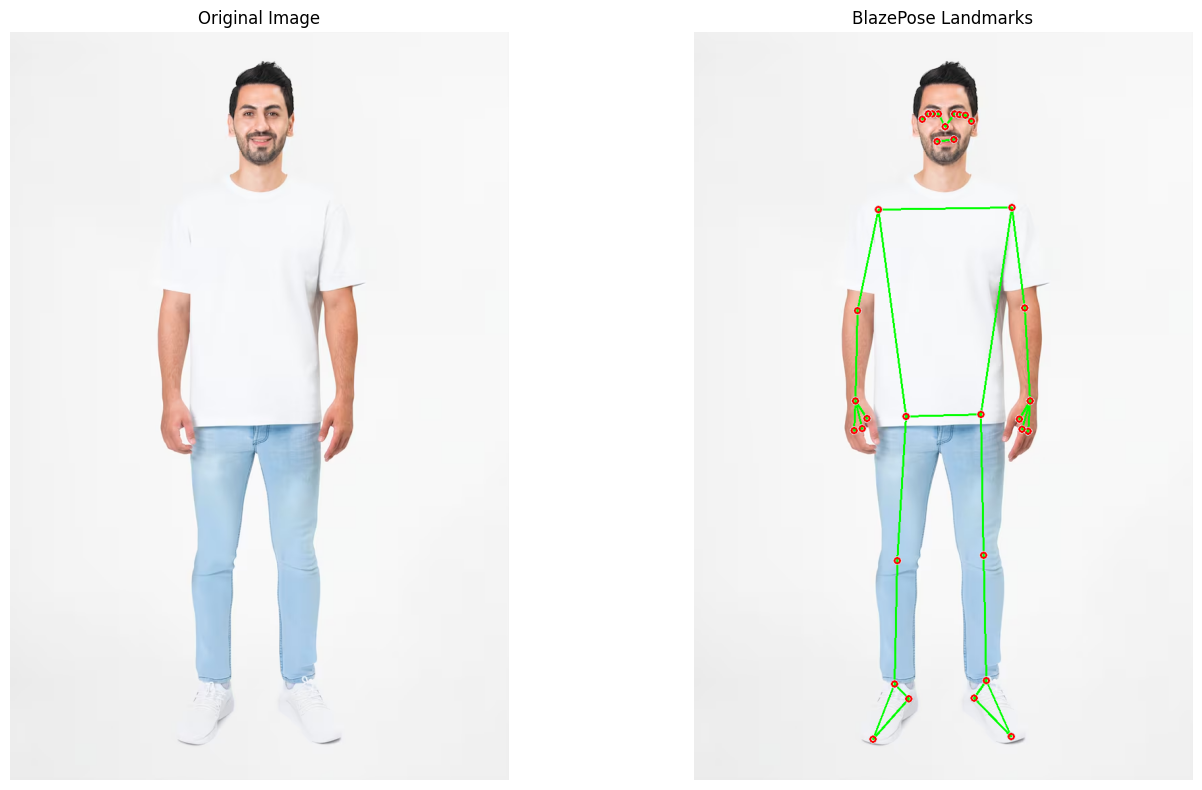

In [35]:
# Display results
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(annotated_image)
axes[1].set_title("BlazePose Landmarks")
axes[1].axis("off")

plt.tight_layout()
plt.show()
